# Importing Libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, cohen_kappa_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

import nltk
from nltk.corpus import stopwords, cmudict
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# Describing Data

In [37]:
dataset_train_path = 'Dataset/train.csv'
dataset_test_path = 'Dataset/test.csv'

In [38]:
df_train = pd.read_csv(dataset_train_path)
df_test = pd.read_csv(dataset_test_path)

In [39]:
df_train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3


In [40]:
df_test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [41]:
print("The shape of the training dataset is: ", df_train.shape)
print("The shape of the testing dataset is: ", df_test.shape)
print("The number of rows in the training dataset is: ", df_train.shape[0])
print("The number of rows in the testing dataset is: ", df_test.shape[0])

The shape of the training dataset is:  (17307, 3)
The shape of the testing dataset is:  (3, 2)
The number of rows in the training dataset is:  17307
The number of rows in the testing dataset is:  3


In [42]:
print("A sample of the full_text column in the training dataset is:\n\n")
print(df_train['full_text'][4])


A sample of the full_text column in the training dataset is:


Dear, State Senator

This is a letter to argue in favor of keeping the Electoral College."There are many reasons to keep the Electoral College" one reason is because it is widely regarded as an anachronism, a dispute over the outcome of an Electoral College vote is possible, but it is less likely than a dispute over the popular vote, and the Electoral College restores some of the weight in the political balance that large states (by population) lose by virue of the mal apportionment of the Senate decreed in the Constitution.

I am in favor of keeping the Electoral College because,it is widely regarded as an anachronism. A non-democratic method of selecting a president that ought to be [overruled] by declaring the canaditdate who receives the most populare votes the winner. The advocates of this position are correct in arguing that the Electoral College method is not democratic in a method sense.It is the electors who elect 

# Data Insights and Visualisation

In [43]:
def count_unique_words(df):
    """
    Counts the number of unique words on the essays in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    num_unique_words (int): Number of unique words in the DataFrame.
    """

    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    unique_words = set(words)
    num_unique_words = len(unique_words)
    
    return num_unique_words

In [44]:
def get_average_essay_length(df):
    """
    Calculates the average length of essays in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_length (float): Average length of essays in terms of word count.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_words = len(words)
    num_essays = len(df)
    average_length = total_words / num_essays
    
    return average_length

In [45]:
def calculate_average_word_length(df):
    """
    Calculates the average length of words used in the essays.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_word_length (float): Average length of words in the essays.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_characters = sum(len(word) for word in words)
    total_words = len(words)
    average_word_length = total_characters / total_words
    
    return average_word_length

In [46]:
def calculate_average_words_per_sentence(df):
    """
    Calculates the average number of words per sentence in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_words (float): Average number of words per sentence.
    """
   
    sentences = [sent_tokenize(essay) for essay in df['full_text']]
    all_sentences = [sentence for essay_sentences in sentences for sentence in essay_sentences]
    total_words = sum(len(word_tokenize(sentence)) for sentence in all_sentences)
    total_sentences = len(all_sentences)
    average_words = total_words / total_sentences
    
    return average_words

In [47]:
def calculate_average_paragraphs_per_essay(df):
    """
    Calculates the average number of paragraphs per essay in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_paragraphs (float): Average number of paragraphs per essay.
    """
    
    df['num_paragraphs'] = df['full_text'].apply(lambda essay: essay.count('\n\n') + 1) 
    average_paragraphs = df['num_paragraphs'].mean()
    
    return average_paragraphs

In [48]:
def calculate_average_sentences_per_paragraph(df):
    """
    Calculates the average number of sentences per paragraph in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_sentences (float): Average number of sentences per paragraph.
    """
   
    df['paragraphs'] = df['full_text'].apply(lambda essay: essay.split('\n\n'))
    all_paragraphs = [paragraph for essay_paragraphs in df['paragraphs'] for paragraph in essay_paragraphs]
    num_sentences_per_paragraph = [len(sent_tokenize(paragraph)) for paragraph in all_paragraphs]
    average_sentences = sum(num_sentences_per_paragraph) / len(num_sentences_per_paragraph)
    
    return average_sentences

In [49]:
def calculate_average_words_per_paragraph(df):
    """
    Calculates the average number of words per paragraph in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_words (float): Average number of words per paragraph.
    """
    
    df['paragraphs'] = df['full_text'].apply(lambda essay: essay.split('\n\n'))
    all_paragraphs = [paragraph for essay_paragraphs in df['paragraphs'] for paragraph in essay_paragraphs]
    num_words_per_paragraph = [len(word_tokenize(paragraph)) for paragraph in all_paragraphs]
    average_words = sum(num_words_per_paragraph) / len(num_words_per_paragraph)
    
    return average_words

In [50]:
def get_most_common_words(df, stopwords_not_included=True, num_words=10):
    """
    Identifies the most common words used in the essays along with their counts.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    stopwords (bool): Whether to include stopwords or not. If true, stopwords will be removed.
    num_words (int): Number of most common words to return.

    Returns:
    common_words (list of tuples): List of tuples containing the most common words and their counts.
    """
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()

    if (stopwords_not_included == True):
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]
    
    word_counts = Counter(words)
    common_words = word_counts.most_common(num_words)

    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
    print(df_common_words)
    
    return common_words

In [51]:
def syllable_count_word(word):
    """
    Counts the number of syllables in a word using the CMU Pronouncing Dictionary.

    Parameters:
    word (str): The word for which syllable count needs to be calculated.

    Returns:
    syllable_count (int): The number of syllables in the word.
    """

    d = cmudict.dict()
    
    if word in d:
        syllable_count = max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    else:
        syllable_count = 1
    
    return syllable_count

def calculate_fkgl(text):
    """
    Calculates the Flesch-Kincaid Grade Level (FKGL) score for a given text.

    Parameters:
    text (str): The text for which FKGL score needs to be calculated.

    Returns:
    fkgl_score (float): The FKGL score of the text.
    """

    sentences = sent_tokenize(text)
    words = [word.lower() for sentence in sentences for word in word_tokenize(sentence)]
    
    syllable_count = 0
    for word in words:
        syllable_count += syllable_count_word(word)

    average_sentence_length = len(words) / len(sentences)
    average_syllables_per_word = syllable_count / len(words)

    fkgl_score = 0.39 * average_sentence_length + 11.8 * average_syllables_per_word - 15.59
    
    return fkgl_score

In [52]:
def plot_essay_length_distribution(df):
    """
    Plots a histogram showing the distribution of essay lengths in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    essay_lengths = [len(words) for words in df['full_text'].str.split()]
    
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(essay_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Essay Lengths')
    plt.xlabel('Length of Essay (Word Count)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [53]:
def plot_class_distribution(df):
    """
    Plots a bar chart showing the distribution of classes in the dataset.

    Parameters:
    df (DataFrame): DataFrame containing the classes.
    """
    
    df['score'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

In [93]:
def plot_essay_length_and_scores(df):
    """
    Plots a scatter plot showing the relationship between essay length and scores.

    Parameters:
    df (DataFrame): DataFrame containing the essays and scores.
    """
        
    essay_lengths = [len(words) for words in df['full_text'].str.split()]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(essay_lengths, df['score'], color='skyblue')
    plt.title('Essay Length vs. Score')
    plt.xlabel('Length of Essay (Word Count)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

In [92]:
def plot_scores_frequency(df):
    """
    Plots a pie chart showing the distribution of scores in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the scores.
    """
    scores = df['score'].value_counts()
    plt.figure(figsize=(12, 6))
    plt.pie(scores.values, labels=scores.index, autopct='%1.1f%%')
    plt.title('Score distribution')
    plt.show()

In [94]:
def get_data_insights(df):
    """
    Generates insights from the dataset.

    """
    
    num_unique_words = count_unique_words(df_train)
    average_essay_length = get_average_essay_length(df_train)
    average_word_length = calculate_average_word_length(df_train)
    average_words_per_sentence = calculate_average_words_per_sentence(df_train)
    average_paragraphs = calculate_average_paragraphs_per_essay(df_train)
    average_sentences = calculate_average_sentences_per_paragraph(df_train)
    average_words = calculate_average_words_per_paragraph(df_train)
    print("Number of unique words in the dataset:", num_unique_words)
    print("Average essay length in the dataset:", average_essay_length)
    print("Average word length in the dataset:", average_word_length)
    print("Average number of words per sentence in the dataset:", average_words_per_sentence)
    print("Average number of paragraphs per essay in the dataset:", average_paragraphs)
    print("Average number of sentences per paragraph in the dataset:", average_sentences)
    print("Average number of words per paragraph in the dataset:", average_words)
    print("Most common words in the dataset:")
    get_most_common_words(df_train)
    plot_essay_length_distribution(df_train)
    plot_class_distribution(df_train)
    plot_essay_length_and_scores(df_train)
    plot_scores_frequency(df_train)

Data Insights for the training dataset:
Number of unique words in the dataset: 129566
Average essay length in the dataset: 368.3482405962905
Average word length in the dataset: 4.557174326035612
Average number of words per sentence in the dataset: 21.421945269988075
Average number of paragraphs per essay in the dataset: 1.0
Average number of sentences per paragraph in the dataset: 19.091812561391343
Average number of words per paragraph in the dataset: 408.9704743745305
Most common words in the dataset:
     Word  Count
0   would  43621
1  people  32374
2    cars  32012
3     car  30530
4   could  29338
5    like  22464
6   Venus  21637
7     get  17290
8    also  16948
9   think  15582


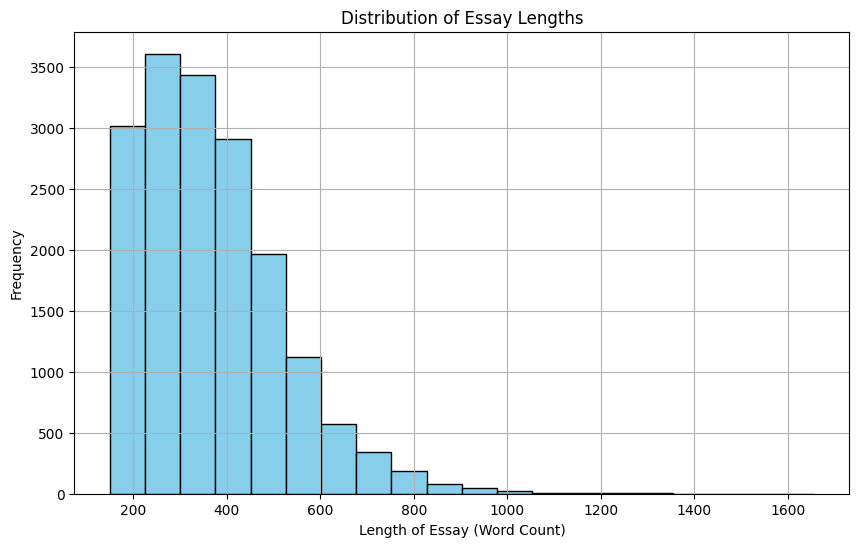

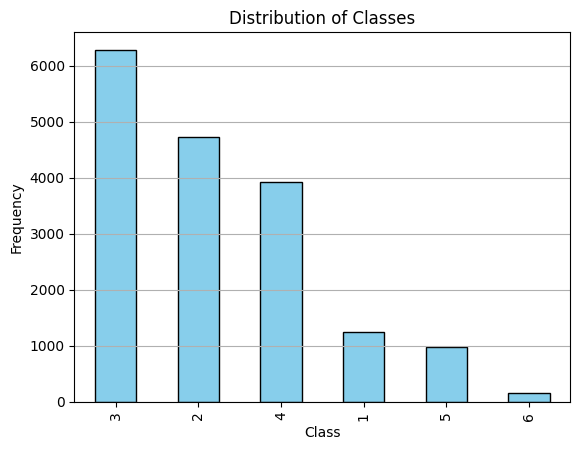

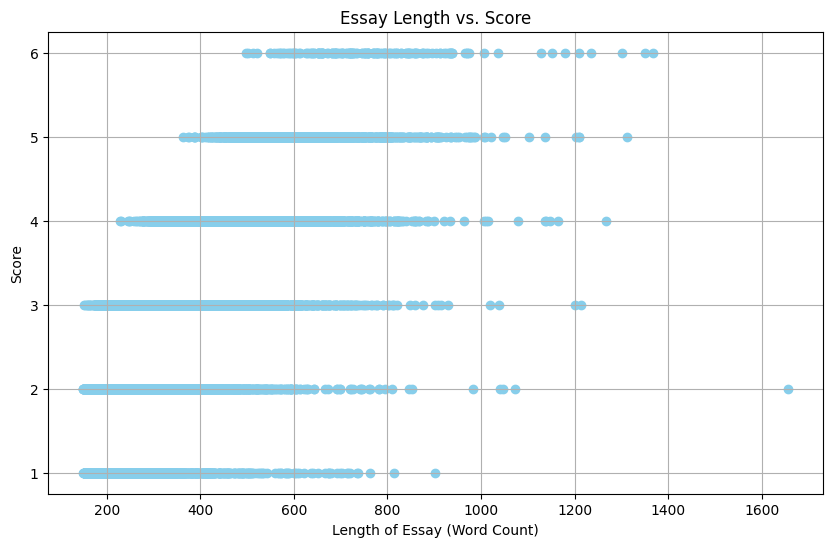

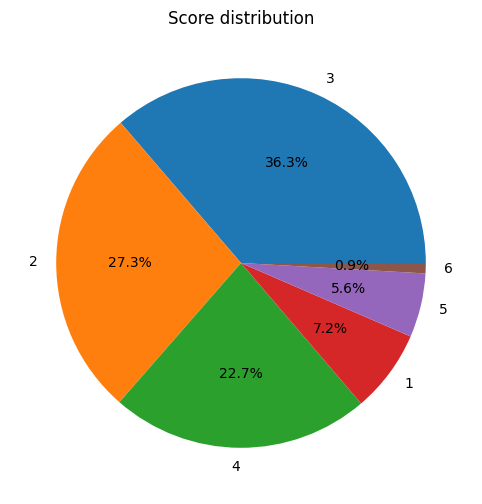

In [95]:
print("Data Insights for the training dataset:")
get_data_insights(df_train)

In [88]:
## number of unique words in each essay
def get_num_unique_words(essay):
    """
    Counts the number of unique words in an essay.

    Parameters:
    essay (str): The essay for which the number of unique words needs to be calculated.

    Returns:
    num_unique_words (int): Number of unique words in the essay.
    """
    
    words = essay.split()
    unique_words = set(words)
    num_unique_words = len(unique_words)
    
    return num_unique_words

In [89]:
# printing number of unique words in each essay
df_train['num_unique_words'] = df_train['full_text'].apply(get_num_unique_words)
df_train


,essay_id,full_text,score,num_paragraphs,paragraphs,full_text_preprocessed,num_unique_words,average_words_per_sentence,average_sentences_per_paragraph,average_words_per_paragraph
0,000d118,Many people have car where they live. The thin...,3,1,[Many people have car where they live. The thi...,many people car live thing dont know use car a...,253,41.923077,13.0,545.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,1,[I am a scientist at NASA that is discussing t...,scientist nasa discussing face mar explaining ...,177,17.666667,21.0,371.0
2,001ab80,People always wish they had the same technolog...,4,1,[People always wish they had the same technolo...,people always wish technology seen movie best ...,253,25.208333,24.0,605.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,"[We all heard about Venus, the planet without ...",heard venus planet without almost oxygen earth...,251,25.550000,20.0,511.0
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3,1,"[Dear, State Senator\r\n\r\nThis is a letter t...",dear state senator letter argue favor keeping ...,162,27.866667,15.0,418.0
...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,1,"[the story "" The Challenge of Exploing Venus ""...",story challenge exploing venus informative pie...,97,18.555556,9.0,167.0
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,1,[Technology has changed a lot of ways that we ...,technology changed lot way live today nowadays...,278,24.769231,26.0,644.0
17304,fff016d,If you don't like sitting around all day than ...,2,1,[If you don't like sitting around all day than...,dont like sitting around day great opportunity...,119,15.666667,15.0,235.0
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,1,"[In ""The Challenge of Exporing Venus,"" the aut...",challenge exporing venus author suggests study...,150,24.000000,11.0,264.0


In [74]:
def plot_num_unique_words_distribution(df):
    """
    Plots a histogram showing the distribution of the number of unique words in each essay.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    plt.figure(figsize=(10, 6))
    plt.hist(df['num_unique_words'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Number of Unique Words in Each Essay')
    plt.xlabel('Number of Unique Words')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

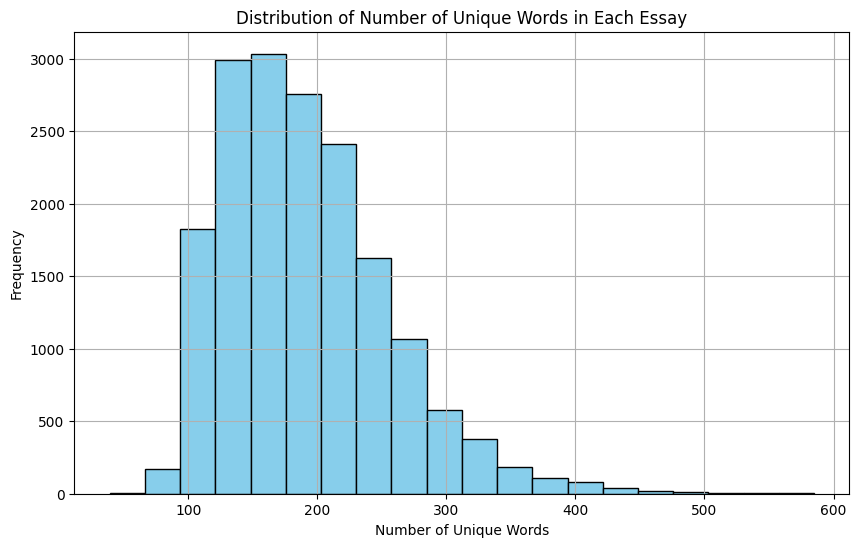

In [75]:
plot_num_unique_words_distribution(df_train)

In [77]:
def plot_num_unique_words_vs_score(df):
    """
    Plots a scatter plot showing the relationship between the number of unique words and the score.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df['num_unique_words'], df['score'], color='skyblue')
    plt.title('Number of Unique Words vs. Score')
    plt.xlabel('Number of Unique Words')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

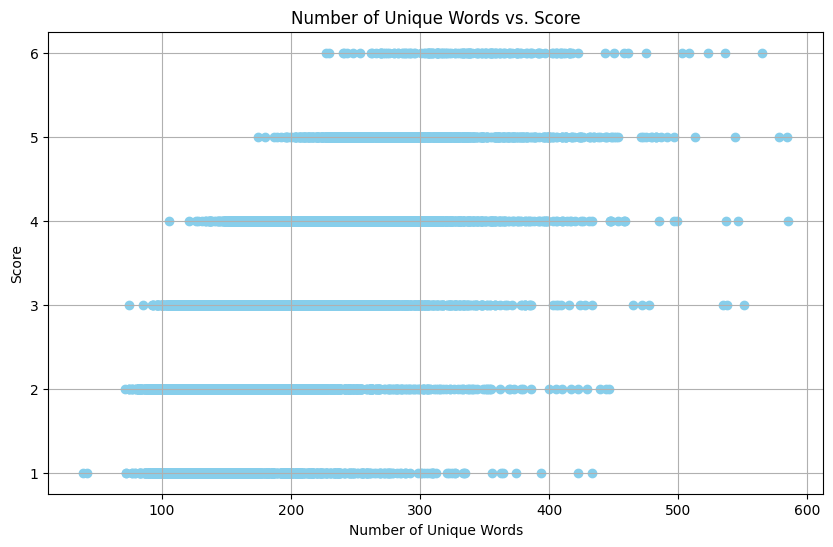

In [78]:
plot_num_unique_words_vs_score(df_train)

In [83]:
## average number of words per sentence in each essay
def get_average_words_per_sentence(essay):
    """
    Calculates the average number of words per sentence in an essay.

    Parameters:
    essay (str): The essay for which the average number of words per sentence needs to be calculated.

    Returns:
    average_words (float): Average number of words per sentence in the essay.
    """
    
    sentences = sent_tokenize(essay)
    num_words = [len(word_tokenize(sentence)) for sentence in sentences]
    average_words = sum(num_words) / len(num_words)
    
    return average_words

# average number of sentences per paragraph in each essay
def get_average_sentences_per_paragraph(essay):
    """
    Calculates the average number of sentences per paragraph in an essay.

    Parameters:
    essay (str): The essay for which the average number of sentences per paragraph needs to be calculated.

    Returns:
    average_sentences (float): Average number of sentences per paragraph in the essay.
    """
    
    paragraphs = essay.split('\n\n')
    num_sentences = [len(sent_tokenize(paragraph)) for paragraph in paragraphs]
    average_sentences = sum(num_sentences) / len(num_sentences)
    
    return average_sentences

def get_average_words_per_paragraph(essay):
    """
    Calculates the average number of words per paragraph in an essay.

    Parameters:
    essay (str): The essay for which the average number of words per paragraph needs to be calculated.

    Returns:
    average_words (float): Average number of words per paragraph in the essay.
    """
    
    paragraphs = essay.split('\n\n')
    num_words = [len(word_tokenize(paragraph)) for paragraph in paragraphs]
    average_words = sum(num_words) / len(num_words)
    
    return average_words


In [84]:
df_train['average_words_per_sentence'] = df_train['full_text'].apply(get_average_words_per_sentence)
df_train['average_sentences_per_paragraph'] = df_train['full_text'].apply(get_average_sentences_per_paragraph)
df_train['average_words_per_paragraph'] = df_train['full_text'].apply(get_average_words_per_paragraph)


In [85]:
df_train

,essay_id,full_text,score,num_paragraphs,paragraphs,full_text_preprocessed,num_unique_words,average_words_per_sentence,average_sentences_per_paragraph,average_words_per_paragraph
0,000d118,Many people have car where they live. The thin...,3,1,[Many people have car where they live. The thi...,many people car live thing dont know use car a...,253,41.923077,13.0,545.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,1,[I am a scientist at NASA that is discussing t...,scientist nasa discussing face mar explaining ...,177,17.666667,21.0,371.0
2,001ab80,People always wish they had the same technolog...,4,1,[People always wish they had the same technolo...,people always wish technology seen movie best ...,253,25.208333,24.0,605.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,1,"[We all heard about Venus, the planet without ...",heard venus planet without almost oxygen earth...,251,25.550000,20.0,511.0
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3,1,"[Dear, State Senator\r\n\r\nThis is a letter t...",dear state senator letter argue favor keeping ...,162,27.866667,15.0,418.0
...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,1,"[the story "" The Challenge of Exploing Venus ""...",story challenge exploing venus informative pie...,97,18.555556,9.0,167.0
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,1,[Technology has changed a lot of ways that we ...,technology changed lot way live today nowadays...,278,24.769231,26.0,644.0
17304,fff016d,If you don't like sitting around all day than ...,2,1,[If you don't like sitting around all day than...,dont like sitting around day great opportunity...,119,15.666667,15.0,235.0
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,1,"[In ""The Challenge of Exporing Venus,"" the aut...",challenge exporing venus author suggests study...,150,24.000000,11.0,264.0


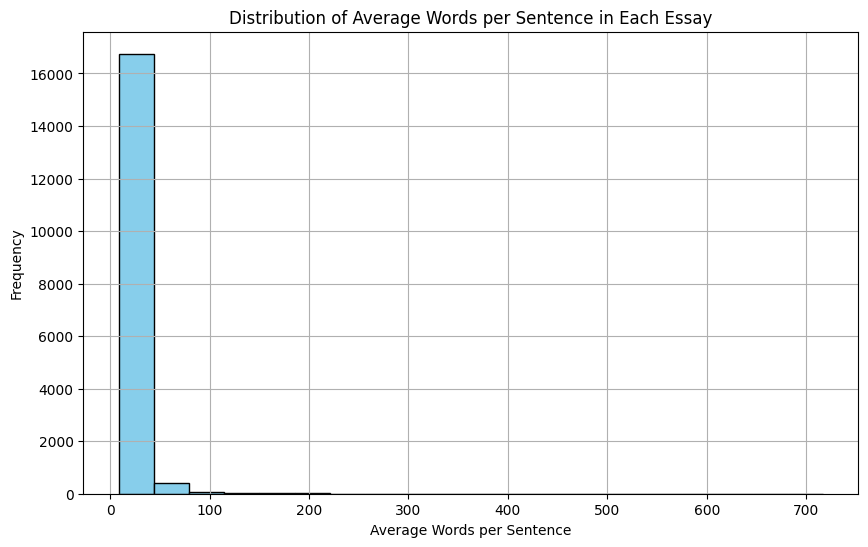

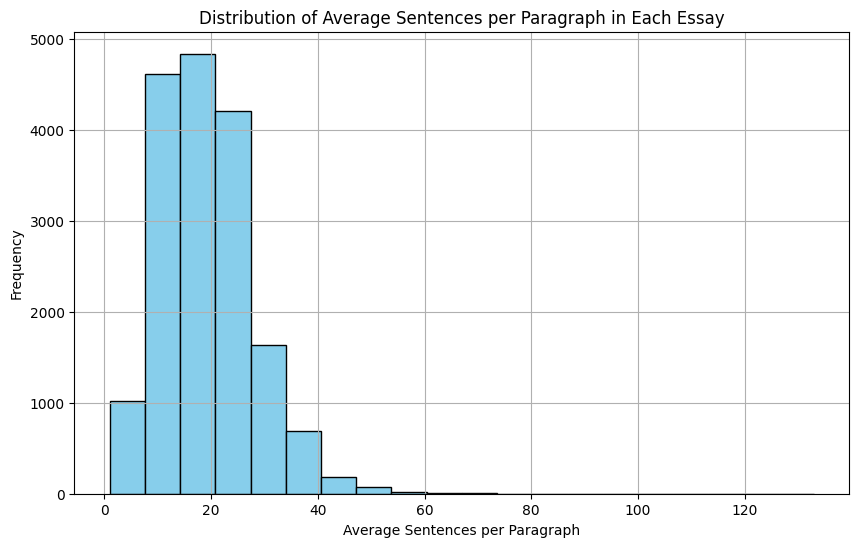

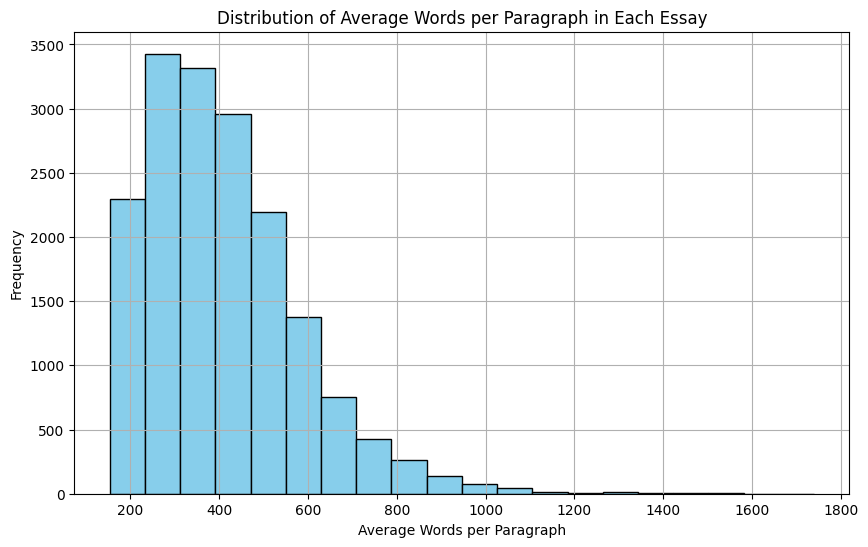

In [86]:

def plot_average_words_per_sentence_distribution(df):
    """
    Plots a histogram showing the distribution of the average number of words per sentence in each essay.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    plt.figure(figsize=(10, 6))
    plt.hist(df['average_words_per_sentence'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Average Words per Sentence in Each Essay')
    plt.xlabel('Average Words per Sentence')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


def plot_average_sentences_per_paragraph_distribution(df):
    """
    Plots a histogram showing the distribution of the average number of sentences per paragraph in each essay.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    plt.figure(figsize=(10, 6))
    plt.hist(df['average_sentences_per_paragraph'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Average Sentences per Paragraph in Each Essay')
    plt.xlabel('Average Sentences per Paragraph')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_average_words_per_paragraph_distribution(df):
    """
    Plots a histogram showing the distribution of the average number of words per paragraph in each essay.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    plt.figure(figsize=(10, 6))
    plt.hist(df['average_words_per_paragraph'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Average Words per Paragraph in Each Essay')
    plt.xlabel('Average Words per Paragraph')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


plot_average_words_per_sentence_distribution(df_train)
plot_average_sentences_per_paragraph_distribution(df_train)
plot_average_words_per_paragraph_distribution(df_train)

## Data Preprocessing

In [56]:
def remove_urls(text):
    """
    Removes URLs from the text.

    Parameters:
    text (str): The text from which URLs need to be removed.

    Returns:
    text (str): Text with URLs removed.
    """

    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def data_preprocessing(df):
    """
    Preprocesses the data by performing the following steps:
    - Lowercasing
    - Removing URLs
    - Removing punctuation
    - Removing stopwords
    - Lemmatization

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    df (DataFrame): DataFrame with preprocessed essays.

    
    """

    for index, row in df.iterrows():
        text_value = row['full_text']

        
        text_value = text_value.lower()
        text_value = remove_urls(text_value)
        text_value = re.sub(r'[^\w\s]', '', text_value)

        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])

        df.at[index, 'full_text_preprocessed'] = text_value

    return df